In [2]:
import sys
sys.path.append('../')
import helper

import numpy as np
from tqdm import tqdm
import torch

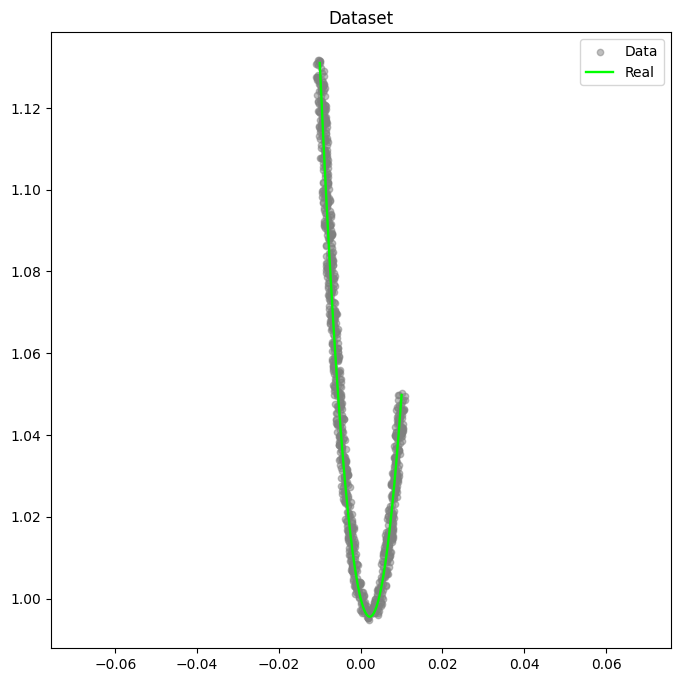

In [38]:
dataset_name = '1'
dataset_params = helper.get_params_dataset(dataset_name)
dataset_filename = helper.get_filenames_datasets()[dataset_name]
f = helper.get_func_research(dataset_params['f_label'])

X, Y, datasets = helper.load_datasets(dataset_filename)

helper.print_generated(X, Y, datasets[0], title="Dataset")

real_w = np.array([dataset_params["w0"], dataset_params["w1"]], dtype=float)

x_train_numpy_all = [dataset[:, :-1] for dataset in datasets]
y_train_numpy_all = [dataset[:, -1:] for dataset in datasets]
x_train_torch_all = [torch.from_numpy(x_train_numpy_all[i]) for i in range(dataset_params["test_count"])]
y_train_torch_all = [torch.from_numpy(y_train_numpy_all[i]) for i in range(dataset_params["test_count"])]

initial_w = np.array([-1.0, 0.1])

eps_minimum_all = [helper.mse_loss_torch(x_train_torch_all[i], torch.from_numpy(y_train_numpy_all[i]), torch.from_numpy(real_w), f)*1.1 for i in range(dataset_params["test_count"])]
eps_mean_minimum_w = sum(eps_minimum_all) / len(eps_minimum_all)
eps_mean_init_w = sum([helper.mse_loss_torch(x_train_torch_all[i], torch.from_numpy(y_train_numpy_all[i]), torch.from_numpy(initial_w), f) for i in range(dataset_params["test_count"])]) / dataset_params["test_count"]

In [4]:
def get_average_loss_history(multi_points):
    k = 0.0

    max_len = 0 
    for points in multi_points:
        max_len = max(max_len, len(points))

    result = []

    for j in tqdm(range(max_len), desc="Get mse loss history"):
        mean = 0.0
        k = 0
        for i in range(len(multi_points)):
            if len(multi_points[i]) > j:
                mean += helper.mse_loss(f, multi_points[i][j], x_train_numpy_all[i], y_train_numpy_all[i])
                k += 1
        result.append(mean / k)

    return result

In [24]:
from operator import itemgetter

def subdict(d, ks):
    return dict(zip(ks, itemgetter(*ks)(d)))

def filter_sub_dict_by_key(dictionary, keys_to_exclude):
    sub_dict = {key: value for key, value in dictionary.items() if key not in keys_to_exclude}
    return sub_dict

In [54]:
import matplotlib.pyplot as plt

def print_mse_loss_history(results_dict, y_max=None):
    print(f'{"Real":45} loss: {eps_mean_minimum_w}')
    for key, value in results_dict.items():
        plt.plot(value, label=key)
        print(f"{key:45} loss:", value[-1], "steps:", len(value))

    if y_max is not None:
        plt.ylim(0, y_max)

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [7]:
results_dict = {}

In [8]:
label = "torch.optim.SGD"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i], initial_w, helper.mse_loss_torch, torch.optim.SGD, lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 551/551 [00:04<00:00, 124.25it/s]


In [9]:
label = "torch.optim.SGD with momentum"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i], initial_w, helper.mse_loss_torch, torch.optim.SGD, lr=10, momentum=0.9))

results_dict[label] = get_average_loss_history(multi_points)

Testing method torch.optim.SGD with momentum:   0%|          | 0/100 [00:00<?, ?it/s]

Get mse loss history: 100%|██████████| 97/97 [00:00<00:00, 101.68it/s]


In [10]:
label = "torch.optim.SGD with Nesterov momentum"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i], initial_w, helper.mse_loss_torch, torch.optim.SGD, lr=10, momentum=0.9, nesterov=True))

results_dict[label] = get_average_loss_history(multi_points)

Testing method torch.optim.SGD with Nesterov momentum: 100%|██████████| 100/100 [00:12<00:00,  7.73it/s]
Get mse loss history: 100%|██████████| 93/93 [00:00<00:00, 105.92it/s]


In [11]:
label = "torch.optim.Adagrad"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i],initial_w, helper.mse_loss_torch, torch.optim.Adagrad, lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 68/68 [00:00<00:00, 113.33it/s]


In [12]:
label = "torch.optim.RMSprop"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i],initial_w, helper.mse_loss_torch, torch.optim.RMSprop, lr=1))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 60/60 [00:00<00:00, 106.48it/s]


In [13]:
label = "torch.optim.Adam"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_torch_optim(f, x_train_torch_all[i], y_train_torch_all[i], eps_minimum_all[i],initial_w, helper.mse_loss_torch, torch.optim.Adam, lr=5))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 73/73 [00:00<00:00, 150.82it/s]


In [14]:
label = "SGD"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_sgd(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 551/551 [00:04<00:00, 123.76it/s]


In [15]:
label = "Momentum"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_momentum(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Testing method Momentum:   0%|          | 0/100 [00:00<?, ?it/s]

Get mse loss history: 100%|██████████| 99/99 [00:00<00:00, 110.18it/s]


In [16]:
label = "Nesterov"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_nesterov(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 95/95 [00:00<00:00, 111.63it/s]


In [17]:
label = "AdaGrad"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_ada_grad(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=10))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 1488/1488 [00:03<00:00, 460.18it/s] 


In [18]:
label = "RMSProp"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_rms_prop(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=0.1))

results_dict[label] = get_average_loss_history(multi_points)

Testing method RMSProp:   0%|          | 0/100 [00:00<?, ?it/s]

Get mse loss history: 100%|██████████| 49/49 [00:00<00:00, 152.89it/s]


In [19]:
label = "Adam"
multi_points = []
for i in tqdm(range(dataset_params["test_count"]), desc=f"Testing method {label}"):
    multi_points.append(helper.train_our_adam(f, x_train_numpy_all[i], y_train_numpy_all[i], eps_minimum_all[i], initial_w, initial_lr=0.5))

results_dict[label] = get_average_loss_history(multi_points)

Get mse loss history: 100%|██████████| 54/54 [00:00<00:00, 112.97it/s]


Real                                          loss: 7.481586253817499e-05
torch.optim.SGD                               loss: 7.753667274059714e-05 steps: 551
SGD                                           loss: 7.756952443600056e-05 steps: 551


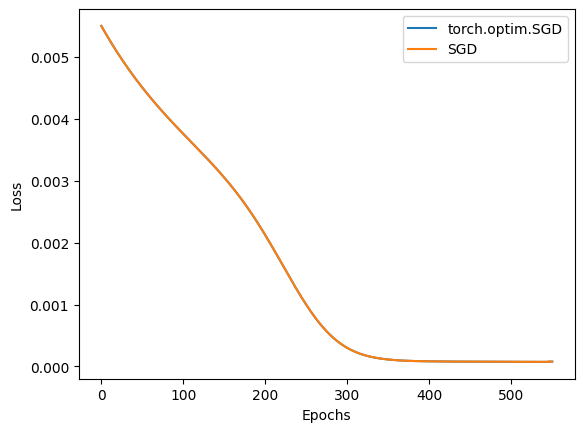

In [57]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.SGD", "SGD"]))

Real                                          loss: 7.481586253817499e-05
torch.optim.Adagrad                           loss: 7.116629643237779e-05 steps: 68
AdaGrad                                       loss: 7.581577268337732e-05 steps: 1488


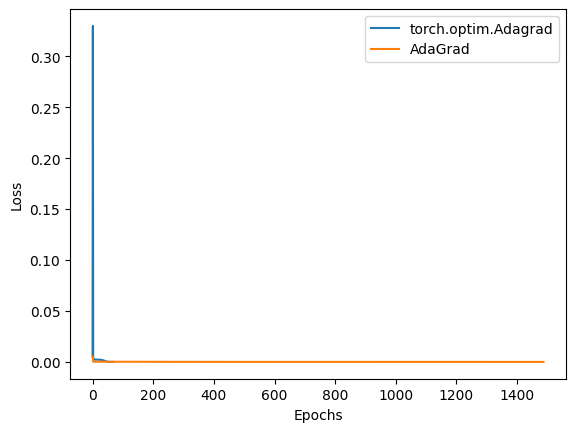

In [61]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.Adagrad", "AdaGrad"]))

Real                                          loss: 7.481586253817499e-05
torch.optim.Adagrad                           loss: 7.116629643237779e-05 steps: 68
AdaGrad                                       loss: 7.581577268337732e-05 steps: 1488


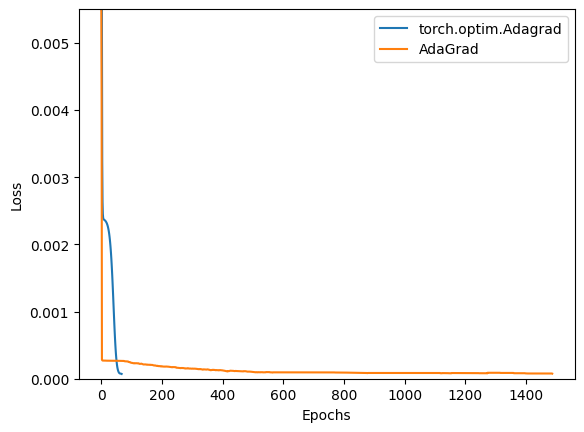

In [56]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.Adagrad", "AdaGrad"]), eps_mean_init_w)

Real                                          loss: 7.481586253817499e-05
torch.optim.SGD with momentum                 loss: 7.458029055847868e-05 steps: 97
Momentum                                      loss: 7.460658043034181e-05 steps: 99


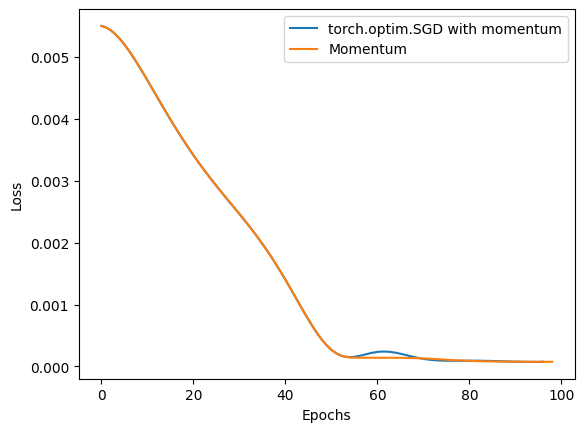

In [55]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.SGD with momentum", "Momentum"]))

Real                                          loss: 7.481586253817499e-05
torch.optim.SGD with Nesterov momentum        loss: 7.412807086024441e-05 steps: 93
Nesterov                                      loss: 7.2714305403977e-05 steps: 95


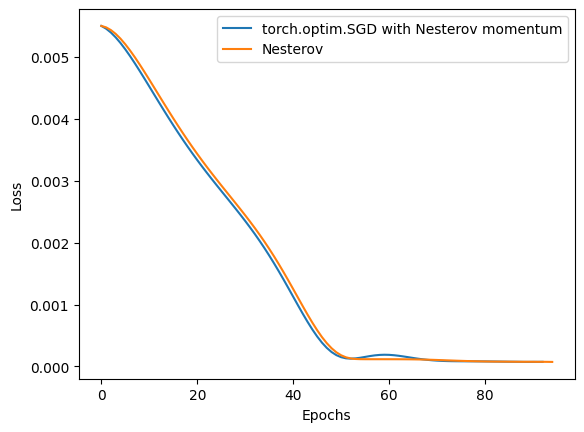

In [58]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.SGD with Nesterov momentum", "Nesterov"]))

Real                                          loss: 7.481586253817499e-05
torch.optim.RMSprop                           loss: 7.001601600272134e-05 steps: 60
RMSProp                                       loss: 6.762658137925631e-05 steps: 49


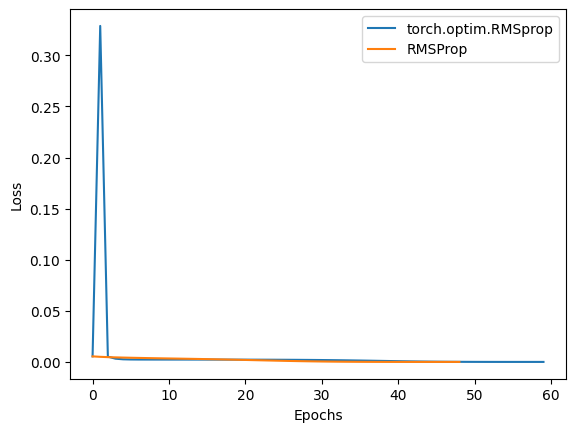

In [60]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.RMSprop", "RMSProp"]))

Real                                          loss: 7.481586253817499e-05
torch.optim.RMSprop                           loss: 7.001601600272134e-05 steps: 60
RMSProp                                       loss: 6.762658137925631e-05 steps: 49


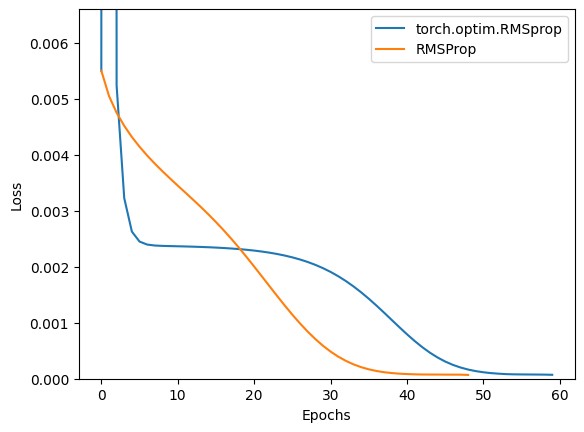

In [65]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.RMSprop", "RMSProp"]), eps_mean_init_w*1.2)

Real                                          loss: 7.481586253817499e-05
torch.optim.Adam                              loss: 6.828866230090804e-05 steps: 73
Adam                                          loss: 7.292588434103817e-05 steps: 54


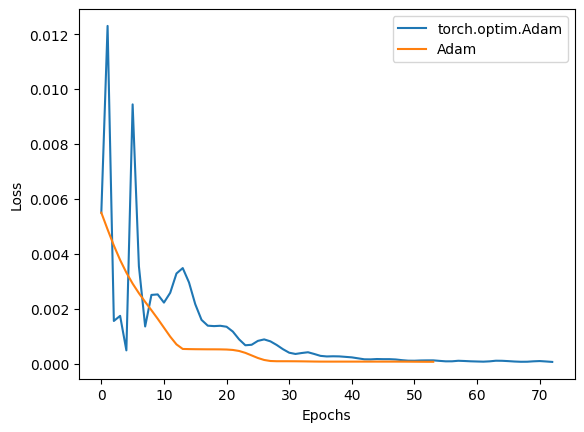

In [66]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.Adam", "Adam"]))

Real                                          loss: 7.481586253817499e-05
torch.optim.SGD with Nesterov momentum        loss: 7.412807086024441e-05 steps: 93
Nesterov                                      loss: 7.2714305403977e-05 steps: 95
torch.optim.SGD                               loss: 7.753667274059714e-05 steps: 551
SGD                                           loss: 7.756952443600056e-05 steps: 551


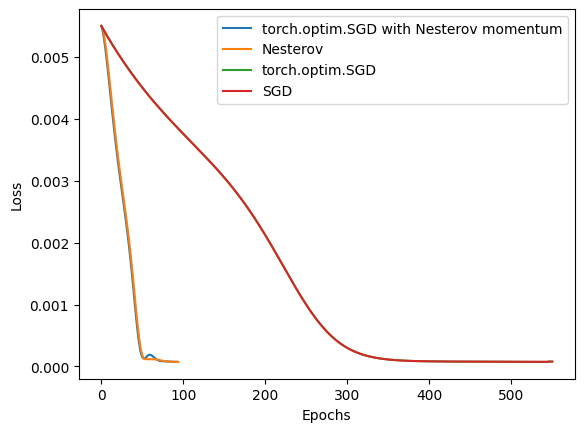

In [68]:
print_mse_loss_history(subdict(results_dict, ["torch.optim.SGD with Nesterov momentum", "Nesterov", "torch.optim.SGD", "SGD"]))

Real                                          loss: 7.481586253817499e-05
torch.optim.SGD with momentum                 loss: 7.458029055847868e-05 steps: 97
torch.optim.SGD with Nesterov momentum        loss: 7.412807086024441e-05 steps: 93
torch.optim.Adagrad                           loss: 7.116629643237779e-05 steps: 68
torch.optim.RMSprop                           loss: 7.001601600272134e-05 steps: 60
torch.optim.Adam                              loss: 6.828866230090804e-05 steps: 73
Momentum                                      loss: 7.460658043034181e-05 steps: 99
Nesterov                                      loss: 7.2714305403977e-05 steps: 95
RMSProp                                       loss: 6.762658137925631e-05 steps: 49
Adam                                          loss: 7.292588434103817e-05 steps: 54


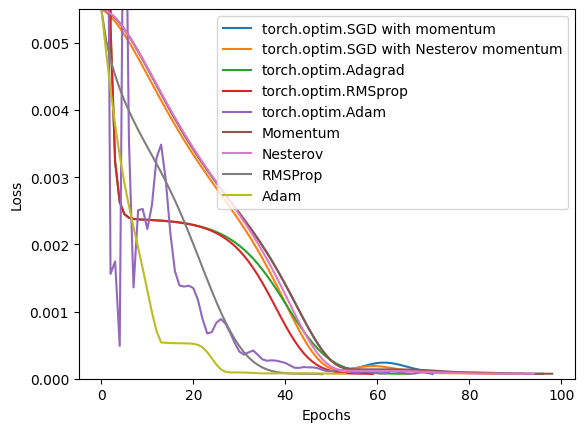

In [59]:
print_mse_loss_history(filter_sub_dict_by_key(results_dict, ["torch.optim.SGD", "SGD", "AdaGrad"]), eps_mean_init_w)

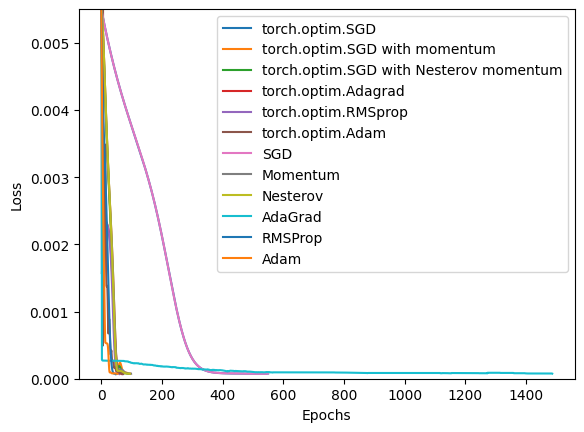

In [21]:
print_mse_loss_history(results_dict, eps_mean_init_w)

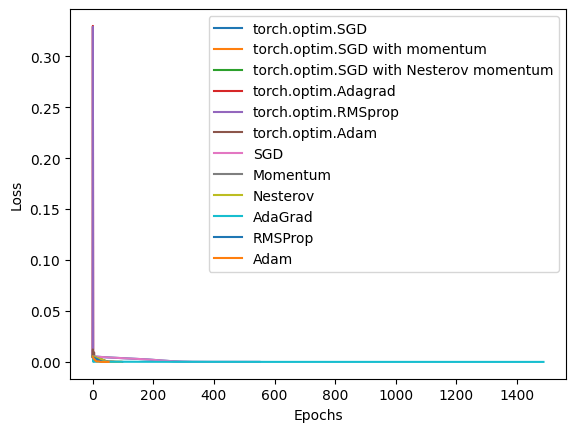

In [22]:
print_mse_loss_history(results_dict)